# Mushroom Classification Pre Processing

## Load the requirements

In [2]:
# run the requirements.txt file for install the necessary packages
!pip install -r mushroom_requirements.txt

## Import Packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import collections

from sklearn import decomposition, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import f_classif, SelectKBest, chi2
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# from pingouin import multivariate_normality
# from factor_analyzer import FactorAnalyzer

#other libraries
import math
from collections import Counter

## Palette Colour for Plot

In [4]:

palette_features = ['#E68753', '#409996']

## Load Data

In [5]:
# Import data yang telah diberikan
data = pd.read_csv('mushroom_cleaned.csv')
data.head()


,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2.0,2.0,10.0,3.807467,1545.0,11,1.804273,1.0
1,1461,2.0,2.0,10.0,3.807467,1557.0,11,1.804273,1.0
2,1371,2.0,2.0,10.0,3.612496,1566.0,11,1.804273,1.0
3,1261,6.0,2.0,10.0,3.787572,1566.0,11,1.804273,1.0
4,1305,6.0,2.0,10.0,3.711971,1464.0,11,0.943195,1.0


In [7]:
# Print dimensi dari data

data.shape

(54041, 9)

In [8]:
# Print ringkasan dari data yang memuat nama kolom, dan tipe data seperti pada gambar dibawah

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54041 entries, 0 to 54040
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cap-diameter     54041 non-null  int64  
 1   cap-shape        54040 non-null  float64
 2   gill-attachment  54039 non-null  float64
 3   gill-color       54040 non-null  float64
 4   stem-height      54040 non-null  float64
 5   stem-width       54040 non-null  float64
 6   stem-color       54041 non-null  int64  
 7   season           54041 non-null  float64
 8   class            54038 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 3.7 MB


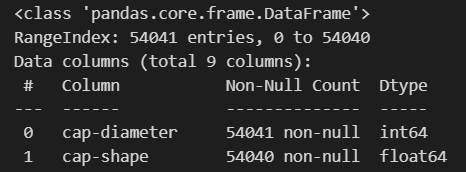

In [9]:
# Mengecek apakah ada missing value pada data
missing_value = ['#NUM!', np.nan, 'NA']

# Read data lagi tetapi menambahkan na_values = missing_value pada command pd.read_csv
data = pd.read_csv('mushroom_cleaned.csv', na_values=missing_value)

data.isnull().sum()

cap-diameter       0
cap-shape          1
gill-attachment    2
gill-color         1
stem-height        1
stem-width         1
stem-color         0
season             0
class              3
dtype: int64

In [10]:
# remove missing value
data.dropna( subset=['cap-shape','gill-attachment','gill-color','stem-height','stem-width','class'], axis=0, inplace=True)
data.isnull().sum()

cap-diameter       0
cap-shape          0
gill-attachment    0
gill-color         0
stem-height        0
stem-width         0
stem-color         0
season             0
class              0
dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54037 entries, 0 to 54040
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cap-diameter     54037 non-null  int64  
 1   cap-shape        54037 non-null  float64
 2   gill-attachment  54037 non-null  float64
 3   gill-color       54037 non-null  float64
 4   stem-height      54037 non-null  float64
 5   stem-width       54037 non-null  float64
 6   stem-color       54037 non-null  int64  
 7   season           54037 non-null  float64
 8   class            54037 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


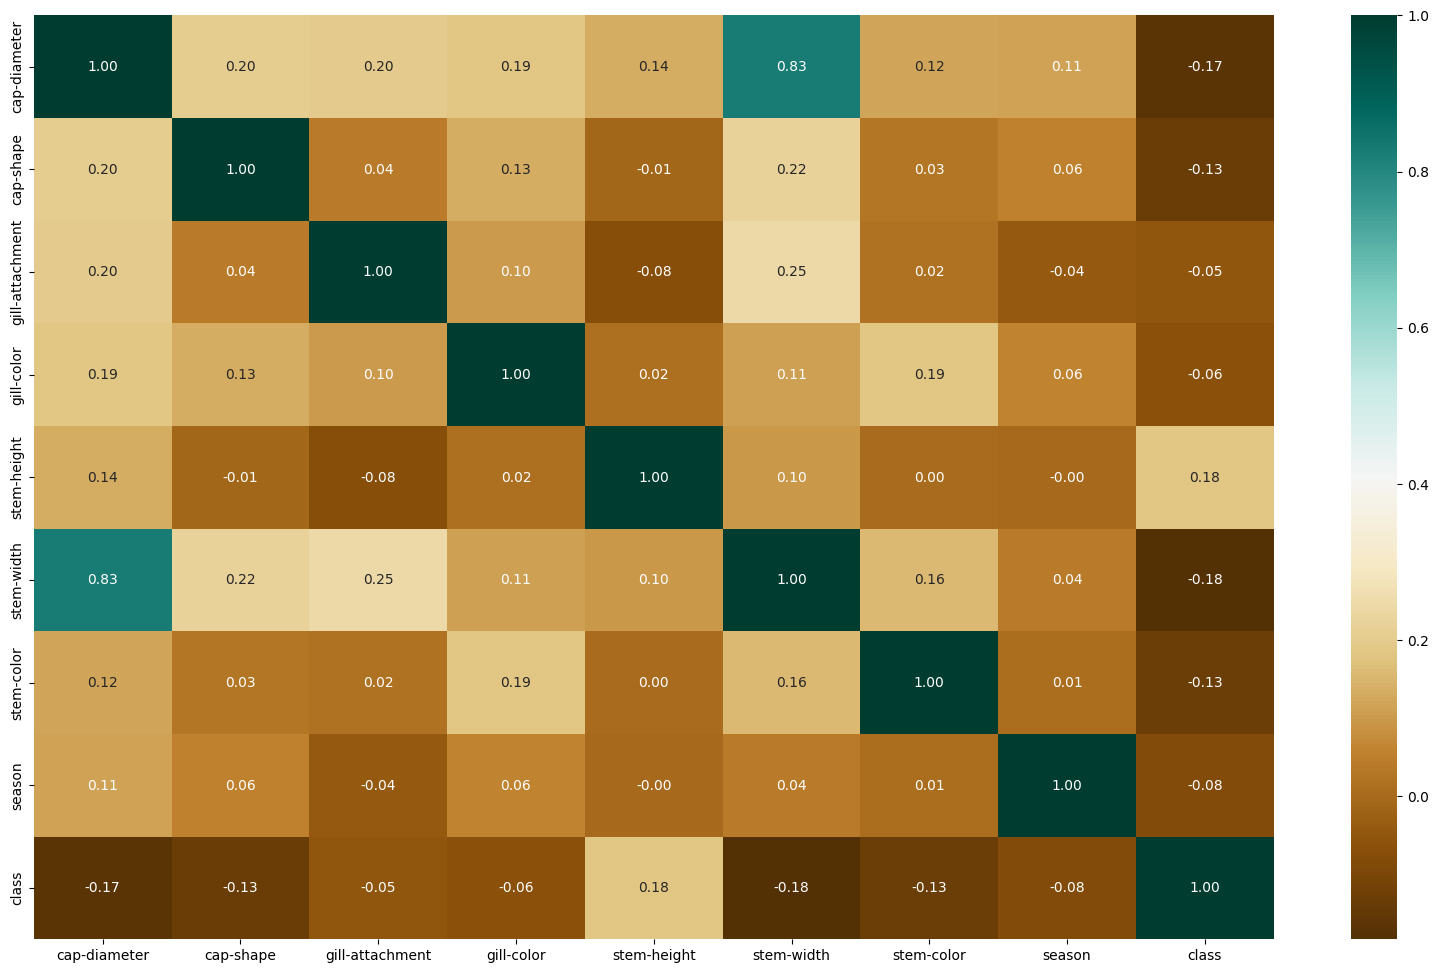

In [12]:
# Membuat Correlation Matrix
corr = data.corr()

plt.figure(figsize = (20, 12))
sns.heatmap(corr, annot=True, fmt = ".2f", cmap="BrBG")
plt.show()

In [13]:
# KMO Test
def kmo(dataset_corr):
    #KMO Test
    #inverse of the correlation matrix
    corr_inv = np.linalg.inv(dataset_corr)
    nrow_inv_corr, ncol_inv_corr = dataset_corr.shape
    
    #partial correlation matrix
    A = np.ones((nrow_inv_corr,ncol_inv_corr))
    for i in range(0,nrow_inv_corr,1):
        for j in range(i,ncol_inv_corr,1):
            #above the diagonal
            A[i,j] = - (corr_inv[i,j]) / (math.sqrt(corr_inv[i,i] * corr_inv[j,j]))
            #below the diagonal
            A[j,i] = A[i,j]
    
    #transform to an array of arrays ("matrix" with Python)
    dataset_corr = np.asarray(dataset_corr)
        
    #KMO value
    kmo_num = np.sum(np.square(dataset_corr)) - np.sum(np.square(np.diagonal(dataset_corr)))
    kmo_denom = kmo_num + np.sum(np.square(A)) - np.sum(np.square(np.diagonal(A)))
    kmo_value = kmo_num / kmo_denom
    
    
    kmo_j = [None]*dataset_corr.shape[1]
    #KMO per variable (diagonal of the spss anti-image matrix)
    for j in range(0, dataset_corr.shape[1]):
        kmo_j_num = np.sum(dataset_corr[:,[j]] ** 2) - dataset_corr[j,j] ** 2
        kmo_j_denom = kmo_j_num + np.sum(A[:,[j]] ** 2) - A[j,j] ** 2
        kmo_j[j] = kmo_j_num / kmo_j_denom

    
    Result = collections.namedtuple("KMO_Test_Results", ["value", "per_variable"])   
    
    #Output of the results - named tuple    
    return Result(value=kmo_value,per_variable=kmo_j)

In [14]:
kmo = kmo(corr)

In [15]:
kmo[1]
# berdasarkan hasil dibawah ini, kita akan drop kolom dengan nilai KMO dibawah 0.5
# nilai KMO dibawah urut dari kolom 1 sampai 9
# silahkan cari tau kolom mana yang harus di drop

[0.5528041816028386,
 0.7976218399727213,
 0.7324021696790948,
 0.5546648024047184,
 0.512269945091815,
 0.548446439396089,
 0.6060664130760648,
 0.456635898521839,
 0.670071373539311]

In [16]:
# Lakukan Copy data terlebih dahulu

data = data.copy()

# Drop kolom dengan KMO dibawah 0.5

data = data.drop(columns=['season'])
data

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,class
0,1372,2.0,2.0,10.0,3.807467,1545.0,11,1.0
1,1461,2.0,2.0,10.0,3.807467,1557.0,11,1.0
2,1371,2.0,2.0,10.0,3.612496,1566.0,11,1.0
3,1261,6.0,2.0,10.0,3.787572,1566.0,11,1.0
4,1305,6.0,2.0,10.0,3.711971,1464.0,11,1.0
...,...,...,...,...,...,...,...,...
54035,73,5.0,3.0,2.0,0.887740,569.0,12,1.0
54036,82,2.0,3.0,2.0,1.186164,490.0,12,1.0
54038,82,5.0,3.0,2.0,0.915593,584.0,12,1.0
54039,79,2.0,3.0,2.0,1.034963,491.0,12,1.0


## Cheking Balance of Y Variable

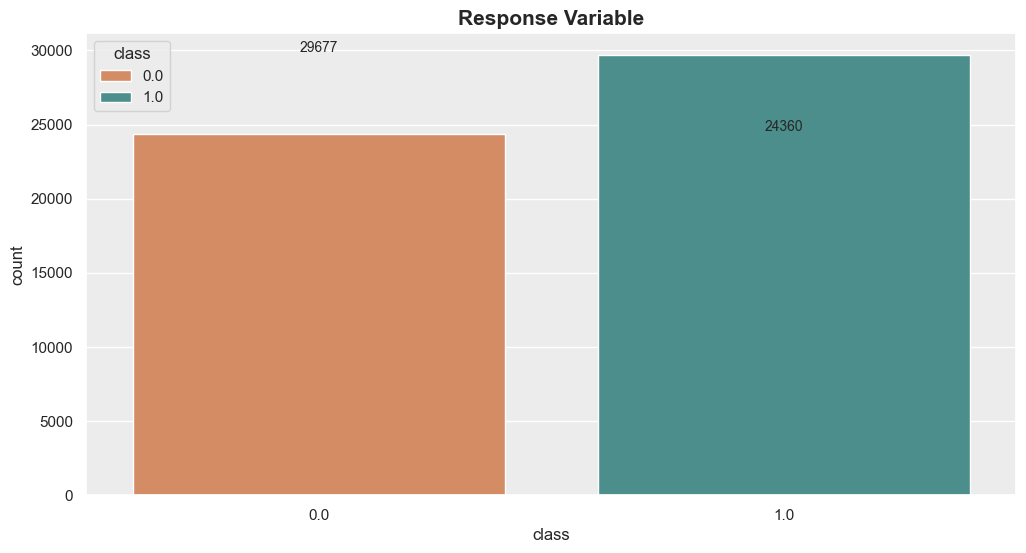

In [17]:
#plot target variable
sns.set(rc={'axes.facecolor':'#ECECEC'}) #background color of plot
plt.figure(figsize=(12,6))
plt.title("Response Variable", fontsize=15, fontweight='bold', fontname='Arial', ha='center')
ax = sns.countplot(x='class', data=data,hue='class', palette=palette_features)

#add labels to each bar
abs_values = data['class'].value_counts(ascending=False).values
for i, v in enumerate(abs_values):
    if v is not None:
        ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10)

#show the plot
plt.show()

## Determine X and Y Variables

In [18]:
columns = data.columns
columns = [c for c in columns if c not in ['class']]
y = data['class'] 
X = data[columns]

## Train Test Splitting

In [19]:
np.random.seed(13)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) #80 % of train data, 20 % of test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((43229, 7), (10808, 7), (43229,), (10808,))

In [ ]:
# Silahkan save masing masing data X_train, X_test, y_train, y_test ke dalam csv

# YOUR CODE HERE